# Imports

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
pd.options.mode.chained_assignment = None

## Final Lung Cancer Data

In [98]:
df = pd.read_excel("../data/lung_cancer_studies_final.xlsx", sheet_name="Sheet1")

df = df[(df["Start Year"] >= 2002) & (df["Start Year"] <= 2021)]
df = df[df["NCT Number"] != "NCT02981108"]
df.dropna(subset=["NCT Number"], inplace=True)
df["Other"] = df["Mixed"] + df["Unknown Race"]
df["minority_number"] = df["Total Number"] - df["White"]

# For rows where "White" is not NaN, assign "has_race" to 1, else 0
df["has_race"] = df["White"].notna().astype(int)

# Same thing but for ethnicity and "Hispanic"
df["has_ethnicity"] = df["Hispanic"].notna().astype(int)
df.loc[df["Funder Type"].isin(["NETWORK", "FED"]), "Funder Type"] = "OTHER"
df["Start Year"] = df["Start Year"].astype(int)

## Lung Cancer Prevalence Data

In [67]:
lung_cancer_prevalence = pd.read_csv("../data/lung_cancer_prevalence.csv")

In [68]:
total_males = lung_cancer_prevalence[lung_cancer_prevalence["Group"] == "Total"]["Males"].values[0]
total_females = lung_cancer_prevalence[lung_cancer_prevalence["Group"] == "Total"]["Females"].values[0]
total_total = lung_cancer_prevalence[lung_cancer_prevalence["Group"] == "Total"]["Total"].values[0]

p2p_ratio_female_ethnicities = lung_cancer_prevalence["Females"] / total_females * lung_cancer_prevalence["PopPercentage"]
p2p_ratio_male_ethnicities = lung_cancer_prevalence["Males"] / total_males * lung_cancer_prevalence["PopPercentage"]
p2p_ratio_total_ethnicities = lung_cancer_prevalence["Total"] / total_total * lung_cancer_prevalence["PopPercentage"]

# concat the two series into a dataframe with Ethnicity as a column

p2p_ratios = pd.DataFrame({
    'Group': lung_cancer_prevalence['Group'],
    'Female_Ratio': p2p_ratio_female_ethnicities,
    'Male_Ratio': p2p_ratio_male_ethnicities,
    'Total_Ratio': p2p_ratio_total_ethnicities
})
p2p_ratios

,Group,Female_Ratio,Male_Ratio,Total_Ratio
0,Asian,0.037912,0.046390,0.042160
1,Black,0.120442,0.150163,0.133424
2,Hispanic,0.092055,0.105436,0.097988
3,Native American,0.010781,0.010044,0.010406
4,Total,1.000000,1.000000,1.000000
5,White,0.623558,0.584468,0.604608
6,Female,0.000000,0.000000,0.457530
7,Male,0.000000,0.000000,0.558360


In [69]:
# Divide each group by its P2P ratio (Group == Group)[Total_Ratio]
df["Asian"] = df["Asian"] / p2p_ratios[p2p_ratios["Group"] == "Asian"]["Total_Ratio"].values[0]
df["Black"] = df["Black"] / p2p_ratios[p2p_ratios["Group"] == "Black"]["Total_Ratio"].values[0]
df["Hispanic"] = df["Hispanic"] / p2p_ratios[p2p_ratios["Group"] == "Hispanic"]["Total_Ratio"].values[0]
df["White"] = df["White"] / p2p_ratios[p2p_ratios["Group"] == "White"]["Total_Ratio"].values[0]
df["Native American"] = df["Native American"] / p2p_ratios[p2p_ratios["Group"] == "Native American"]["Total_Ratio"].values[0]
df["Female"] = df["Female"] / p2p_ratios[p2p_ratios["Group"] == "Female"]["Total_Ratio"].values[0]
df["Male"] = df["Male"] / p2p_ratios[p2p_ratios["Group"] == "Male"]["Total_Ratio"].values[0]
df["minority_ppr"] = df["minority_number"] / (1 - p2p_ratios[p2p_ratios["Group"] == "White"]["Total_Ratio"].values[0])

In [70]:
# Things to Analyze:
# 1. Rate of minority participation (non-white) by year. Need a trendline and p-value for it
# 2. Rate of female participation by year with same recs
# 3. Rate of Hispanic participation by year with same
# 4. Comparison of minority/Hispanic/female participation by if surgery is offered or if it's a drug offered
# 5. Does the rate of female/minority/Hispanic participation charge by funding type? 
# 6. Has reporting of ethnicity or race changed over time?

In [71]:
# 1. Rate of minority participation (non-white) by year. Need a trendline and p-value for it
race_columns = ["Native American", "Black", "Other", "Asian", "Pacific", "White"]
minority_participation_agg = df.groupby("Start Year").agg({k: "sum" for k in race_columns}).reset_index()
minority_participation_agg = minority_participation_agg.astype(int)
minority_participation_agg["total_participants"] = minority_participation_agg.apply("sum", axis=1) - minority_participation_agg["Start Year"]
minority_participation_agg["minority_participants"] = minority_participation_agg["total_participants"] - minority_participation_agg["White"]
minority_participation_agg["minority_participation_rate"] = minority_participation_agg["minority_participants"] / minority_participation_agg["total_participants"]
minority_participation_agg = minority_participation_agg[(minority_participation_agg["Start Year"] >= 2002) & (minority_participation_agg["Start Year"] <= 2021)]

In [72]:
# Linear regression on minorty participation rate over time from 2002-2021
x = minority_participation_agg["Start Year"]
y = minority_participation_agg["minority_participation_rate"]
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)
print("p-value: %f" % p_value)
print("std_err: %f" % std_err)

slope: 0.005730    intercept: -10.982102
R-squared: 0.321392
p-value: 0.009147
std_err: 0.001963


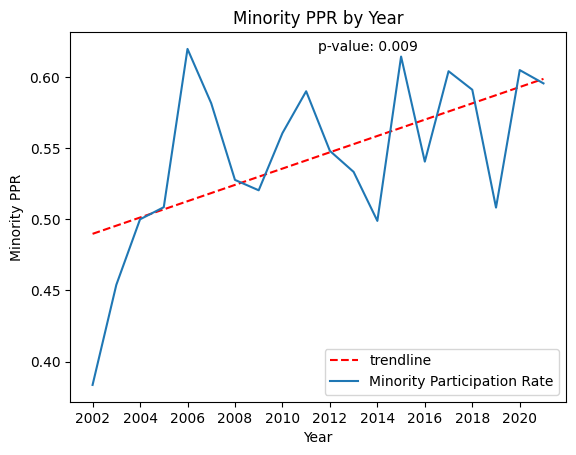

In [73]:
x = minority_participation_agg["Start Year"]
y = minority_participation_agg["minority_participation_rate"]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.plot(x, intercept + slope*x, '--r', label='trendline')
plt.annotate(f"p-value: {p_value:.3f}", xy=(0.50, 0.95), xycoords='axes fraction')

# Plot the minority participation rate by year.
plt.plot(minority_participation_agg["Start Year"], minority_participation_agg["minority_participation_rate"], label="Minority Participation Rate")
plt.xlabel("Year")
plt.xticks(minority_participation_agg["Start Year"][::2])
plt.ylabel("Minority PPR")
plt.title("Minority PPR by Year")
plt.legend()
# plt.savefig("plots/minority_ppr_by_year.png", dpi=1200)
# plt.savefig("plots/minority_ppr_by_year.svg", format="svg", dpi=1200)
plt.show()

In [74]:
# 2. Rate of female participation by year. "Female" and "Male" are the columns
gender_columns = ["Female", "Male"]
gender_participation_agg = df.groupby("Start Year").agg({k: "sum" for k in gender_columns}).reset_index()
gender_participation_agg = gender_participation_agg.astype(int)
gender_participation_agg["total_participants"] = gender_participation_agg.apply("sum", axis=1) - gender_participation_agg["Start Year"]
gender_participation_agg["female_participation_rate"] = gender_participation_agg["Female"] / gender_participation_agg["total_participants"]
gender_participation_agg = gender_participation_agg[(minority_participation_agg["Start Year"] >= 2002) & (gender_participation_agg["Start Year"] <= 2021)]

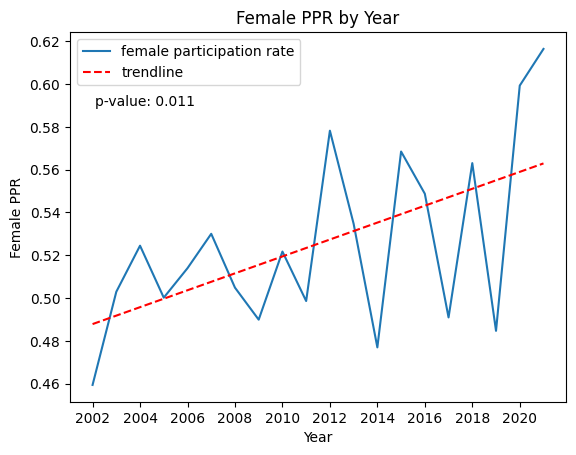

In [75]:
# Plot the female participation rate by year.
plt.plot(gender_participation_agg["Start Year"], gender_participation_agg["female_participation_rate"], label="female participation rate")
plt.xlabel("Year")
plt.xticks(gender_participation_agg["Start Year"][::2])
plt.ylabel("Female PPR")
plt.title("Female PPR by Year")

# Add trendline and p-value annotation
from scipy import stats
x = gender_participation_agg["Start Year"]
y = gender_participation_agg["female_participation_rate"]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.plot(x, intercept + slope*x, '--r', label='trendline')
plt.annotate(f"p-value: {p_value:.3f}", xy=(0.05, 0.80), xycoords='axes fraction')

plt.legend()
# plt.savefig("plots/female_ppr_by_year.png", dpi=1200)
# plt.savefig("plots/female_ppr_by_year.svg", format="svg", dpi=1200)
plt.show()

In [76]:
# 1. Rate of Hispanic participation by year. "Hispanic" is the column, "Non-His" and "Unknown Ethnicity" are the other columns
hispanic_agg = df.groupby("Start Year").agg({"Hispanic": "sum", "Non-His": "sum", "Unknown Ethnicity": "sum"}).reset_index()
hispanic_agg = hispanic_agg.astype(int)
hispanic_agg["total_participants"] = hispanic_agg.apply("sum", axis=1) - hispanic_agg["Start Year"]
hispanic_agg["hispanic_participation_rate"] = hispanic_agg["Hispanic"] / hispanic_agg["total_participants"]
hispanic_agg = hispanic_agg[(hispanic_agg["Start Year"] >= 2002) & (hispanic_agg["Start Year"] <= 2021)]

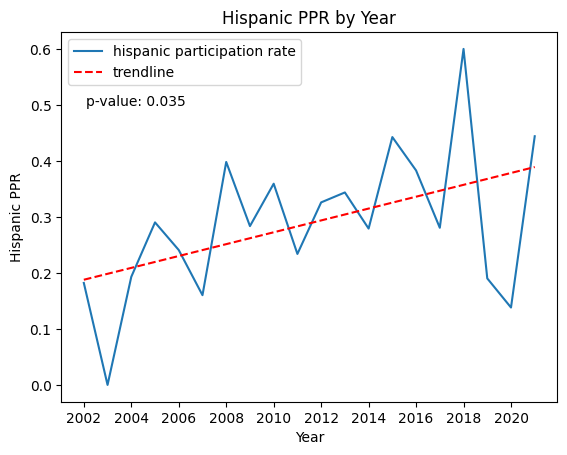

In [77]:
# Plot the hispanic participation rate by year.
plt.plot(hispanic_agg["Start Year"], hispanic_agg["hispanic_participation_rate"], label="hispanic participation rate")
plt.xlabel("Year")
plt.xticks(hispanic_agg["Start Year"][::2])
plt.ylabel("Hispanic PPR")
plt.title("Hispanic PPR by Year")

# Add trendline and p-value annotation
from scipy import stats
x = hispanic_agg["Start Year"]
y = hispanic_agg["hispanic_participation_rate"]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.plot(x, intercept + slope*x, '--r', label='trendline')
plt.annotate(f"p-value: {p_value:.3f}", xy=(0.05, 0.80), xycoords='axes fraction')
plt.legend()
# plt.savefig("plots/hispanic_ppr_by_year.png", dpi=1200)
# plt.savefig("plots/hispanic_ppr_by_year.svg", format="svg", dpi=1200)
plt.show()

In [78]:
# Check if the difference in minority participation rate is significant
minority_df = df[df["White"].notna()]
minority_surgery_participation = df.groupby("Surgery?").agg({"minority_number": "sum", "Total Number": "sum"}).reset_index()
minority_surgery_participation["minority_surgery_participation_rate"] = minority_surgery_participation["minority_number"] / minority_surgery_participation["Total Number"]
minority_surgery_participation["minority_surgery_ppr"] = minority_surgery_participation["minority_surgery_participation_rate"] / (1 - p2p_ratios[p2p_ratios["Group"] == "White"]["Total_Ratio"].values[0])

In [79]:
minority_surgery_participation

,Surgery?,minority_number,Total Number,minority_surgery_participation_rate,minority_surgery_ppr
0,0.0,4194.0,96408.0,0.043503,0.110024
1,1.0,16.0,388.0,0.041237,0.104294


In [80]:
# Repeat for women
women_surgery_participation = df.groupby("Surgery?").agg({"Female": "sum", "Total Number": "sum"}).reset_index()
women_surgery_participation["female_participation_rate"] = women_surgery_participation["Female"] / women_surgery_participation["Total Number"]

In [81]:
# Check if the difference in minority participation rate is significant
df["female_participation_rate"] = df["Female"] / df["Total Number"]
women_surgery_participation_yes = df[df["Surgery?"] == 1.0]
# fillna(0) because there are some NaN values in the minority participation rate column
women_surgery_participation_yes["female_participation_rate"].fillna(0, inplace=True)
women_surgery_participation_no = df[df["Surgery?"] == 0.0]
women_surgery_participation_no["female_participation_rate"].fillna(0, inplace=True)
stats.ttest_ind(women_surgery_participation_yes["female_participation_rate"], women_surgery_participation_no["female_participation_rate"])

/var/folders/ff/n4_3h2kn6txffd6w4pltkmzw0000gn/T/ipykernel_9258/3932080478.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  women_surgery_participation_yes["female_participation_rate"].fillna(0, inplace=True)
/var/folders/ff/n4_3h2kn6txffd6w4pltkmzw0000gn/T/ipykernel_9258/3932080478.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

TtestResult(statistic=-0.15332108771657313, pvalue=0.8781860400137722, df=755.0)

In [82]:
women_surgery_participation

,Surgery?,Female,Total Number,female_participation_rate
0,0.0,91806.001792,96408.0,0.952265
1,1.0,408.716368,388.0,1.053393


In [83]:
# subset where "Hispanic" is not NaN
hispanic_df = df[df["Hispanic"].notna()]
hispanic_surgery_participation = hispanic_df.groupby("Surgery?").agg({"Hispanic": "sum", "Total Number": "sum"}).reset_index()
hispanic_surgery_participation["hispanic_participation_rate"] = hispanic_surgery_participation["Hispanic"] / hispanic_surgery_participation["Total Number"]
hispanic_surgery_participation

,Surgery?,Hispanic,Total Number,hispanic_participation_rate
0,0.0,7949.953055,16030.0,0.495942
1,1.0,0.000000,57.0,0.000000


In [84]:
# Merge minority_surgery_participation, women_surgery_participation, and hispanic_surgery_participation into one dataframe on Surgery?, keeping 
# only the columns for the rates
dfs_to_merge = [minority_surgery_participation, women_surgery_participation, hispanic_surgery_participation]
merged_df = dfs_to_merge[0]
for surgery_df in dfs_to_merge[1:]:
    merged_df = pd.merge(merged_df, surgery_df, on="Surgery?")

merged_df = merged_df[["Surgery?", "minority_surgery_participation_rate", "female_participation_rate", "hispanic_participation_rate", "minority_surgery_ppr"]]
merged_df.columns = ["Surgery?", "minority_surgery_participation_rate", "female_surgery_participation_rate", "hispanic_surgery_participation_rate", "minority_surgery_ppr"]

In [85]:
merged_df

,Surgery?,minority_surgery_participation_rate,female_surgery_participation_rate,hispanic_surgery_participation_rate,minority_surgery_ppr
0,0.0,0.043503,0.952265,0.495942,0.110024
1,1.0,0.041237,1.053393,0.000000,0.104294


In [86]:
women_surgery_participation

,Surgery?,Female,Total Number,female_participation_rate
0,0.0,91806.001792,96408.0,0.952265
1,1.0,408.716368,388.0,1.053393


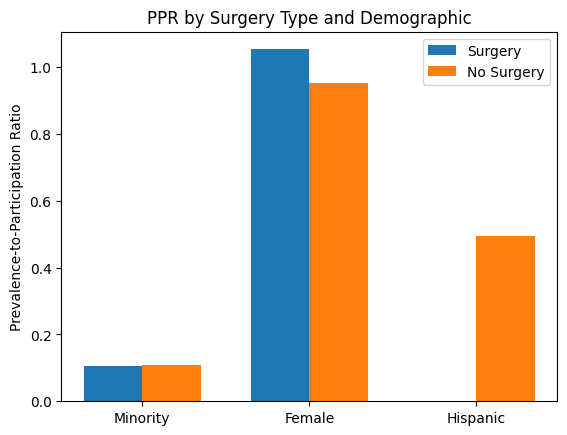

In [87]:
# Plot participation rates for both surgery and non-surgery as bar charts.
# x-axis is participation type: minority_surgery_participation_rate, female_participation_rate, hispanic_participation_rate
# Surgery? == 1.0 is surgery, Surgery? == 0.0 is no surgery. Group the two surgery types together for each participation type.
# y-axis is participation rate
participation_types = ["Minority", "Female", "Hispanic"]
surgery_participation_rates = [merged_df[merged_df["Surgery?"] == 1.0]["minority_surgery_ppr"].mean(),
                              merged_df[merged_df["Surgery?"] == 1.0]["female_surgery_participation_rate"].mean(),
                              merged_df[merged_df["Surgery?"] == 1.0]["hispanic_surgery_participation_rate"].mean()]
no_surgery_participation_rates = [merged_df[merged_df["Surgery?"] == 0.0]["minority_surgery_ppr"].mean(),
                                  merged_df[merged_df["Surgery?"] == 0.0]["female_surgery_participation_rate"].mean(),
                                  merged_df[merged_df["Surgery?"] == 0.0]["hispanic_surgery_participation_rate"].mean()]

x = np.arange(len(participation_types))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, surgery_participation_rates, width, label='Surgery')
rects2 = ax.bar(x + width/2, no_surgery_participation_rates, width, label='No Surgery')

ax.set_ylabel('Prevalence-to-Participation Ratio')
ax.set_title('PPR by Surgery Type and Demographic')
ax.set_xticks(x)
ax.set_xticklabels(participation_types)
ax.legend()
plt.savefig("../plots/ppr_by_surgery_and_demographic.png", dpi=1200)
plt.savefig("../plots/ppr_by_surgery_and_demographic.svg", format="svg", dpi=1200)
plt.show()

In [92]:
merged_df

,Surgery?,minority_surgery_participation_rate,female_surgery_participation_rate,hispanic_surgery_participation_rate,minority_surgery_ppr
0,0.0,0.043503,0.952265,0.495942,0.110024
1,1.0,0.041237,1.053393,0.000000,0.104294


In [96]:
df.columns

Index(['NCT Number', 'Study Title', 'Study URL', 'Study Status',
       'Study Results', 'Conditions', 'Interventions', 'Surgery?', 'Drug?',
       'Behavioural?', 'Observational?', 'Phases', 'Funder Type', 'Study Type',
       'Results First Posted', 'Locations', 'Zipcodes', 'Female', 'Male',
       'Total Number', 'Mean', 'Median', 'Native American', 'Asian', 'Pacific',
       'Black', 'White', 'Mixed', 'Unknown Race', 'Hispanic', 'Non-His',
       'Unknown Ethnicity', 'Race/Ethnicity Flag', 'Start Year', 'has_race',
       'has_ethnicity', 'Other', 'minority_number', 'minority_ppr',
       'female_participation_rate'],
      dtype='object')

In [102]:
df[df["Surgery?"] == 1.0][["Total Number", "Female", "minority_number", "Hispanic"]]

# make this into a publication ready table

,Total Number,Female,minority_number,Hispanic
5,19.0,9.0,2.0,NaN
11,44.0,12.0,4.0,NaN
36,15.0,6.0,NaN,NaN
68,25.0,13.0,NaN,NaN
78,38.0,19.0,NaN,NaN
83,32.0,18.0,0.0,0.0
87,22.0,12.0,NaN,NaN
96,40.0,20.0,NaN,NaN
173,8.0,2.0,NaN,NaN
220,9.0,4.0,2.0,NaN


In [50]:
# 5. Does the rate of female/minority/Hispanic participation charge by funding type?

In [51]:
minority_df = df[df["White"].notna()]
minority_df["minority_participation_rate"] = minority_df["minority_number"] / minority_df["Total Number"]
minority_funder_participation = df.groupby("Funder Type").agg({"minority_number": "sum", "Total Number": "sum"}).reset_index()
minority_funder_participation["minority_participation_rate"] = minority_funder_participation["minority_number"] / minority_funder_participation["Total Number"]
minority_funder_participation

,Funder Type,minority_number,Total Number,minority_participation_rate
0,INDUSTRY,1428.0,13833.0,0.103231
1,NIH,551.0,58370.0,0.009440
2,OTHER,2231.0,24593.0,0.090717


In [52]:
minority_df

,NCT Number,Study Title,Study URL,Study Status,Study Results,Conditions,Interventions,Surgery?,Drug?,Behavioural?,...,Unknown Ethnicity,Race/Ethnicity Flag,Start Year,has_race,has_ethnicity,Other,minority_number,minority_ppr,female_participation_rate,minority_participation_rate
5,NCT00043108,"Combination Chemotherapy, Surgery, and Radiati...",https://clinicaltrials.gov/study/NCT00043108,COMPLETED,YES,Lung Cancer,DRUG: carboplatin|DRUG: paclitaxel|PROCEDURE: ...,1.0,1.0,0.0,...,NaN,1.0,2002,1,0,0.0,2.0,5.058271,1.035307,0.105263
6,NCT00045162,S0124: Cisplatin Combined With Irinotecan or E...,https://clinicaltrials.gov/study/NCT00045162,COMPLETED,YES,Lung Cancer,DRUG: cisplatin|DRUG: etoposide|DRUG: irinotec...,0.0,1.0,0.0,...,60.0,1.0,2002,1,1,8.0,47.0,118.869375,0.943421,0.072197
11,NCT00062439,S0220: Chemoradiotherapy Followed By Surgery a...,https://clinicaltrials.gov/study/NCT00062439,COMPLETED,YES,Lung Cancer,DRUG: cisplatin|DRUG: docetaxel|DRUG: etoposid...,1.0,1.0,0.0,...,NaN,1.0,2003,1,0,0.0,4.0,10.116543,0.596086,0.090909
17,NCT00066742,Tirapazamine Combined With Chemo and RT in Lim...,https://clinicaltrials.gov/study/NCT00066742,COMPLETED,YES,Limited Stage Small Cell Lung Cancer,DRUG: tirapazamine|DRUG: cisplatin|DRUG: etopo...,0.0,1.0,0.0,...,NaN,1.0,2003,1,0,0.0,5.0,12.645678,1.221392,0.073529
21,NCT00084487,Rebeccamycin Analog as Second-Line Therapy in ...,https://clinicaltrials.gov/study/NCT00084487,TERMINATED,YES,Extensive Stage Small Cell Lung Cancer|Limited...,DRUG: becatecarin,0.0,1.0,0.0,...,NaN,1.0,2004,1,0,0.0,4.0,10.116543,1.092825,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,NCT04750239,Safety and Clinical Activity of Nivatrotamab i...,https://clinicaltrials.gov/study/NCT04750239,TERMINATED,YES,SCLC,DRUG: Nivatrotamab,0.0,1.0,0.0,...,0.0,1.0,2021,1,1,0.0,0.0,0.000000,1.457099,0.000000
766,NCT04863248,"Trilaciclib, a CDK 4/6 Inhibitor, in Patients ...",https://clinicaltrials.gov/study/NCT04863248,TERMINATED,YES,Metastatic Non-Small Cell Lung Cancer|NSCLC|Lu...,DRUG: Trilaciclib|DRUG: Placebo|DRUG: Docetaxel,0.0,1.0,0.0,...,0.0,1.0,2021,1,1,0.0,3.0,7.587407,0.936707,0.428571
767,NCT04940221,Testing Informed Decision Making in Lung Cance...,https://clinicaltrials.gov/study/NCT04940221,COMPLETED,YES,Lung Cancer,BEHAVIORAL: Shared Decision Making,0.0,0.0,1.0,...,0.0,1.0,2018,1,1,0.0,14.0,35.407899,1.092825,0.175000
768,NCT04971187,Bintrafusp Alfa With Chemotherapy for Tyrosine...,https://clinicaltrials.gov/study/NCT04971187,TERMINATED,YES,Locally Advanced Lung Non-Squamous Non-Small C...,DRUG: Bintrafusp Alfa|DRUG: Pemetrexed|DRUG: C...,0.0,1.0,0.0,...,0.0,1.0,2021,1,1,0.0,0.0,0.000000,0.728550,0.000000


In [53]:
# Repeat the above for female participation
women_funder_participation = df.groupby("Funder Type").agg({"Female": "sum", "Total Number": "sum"}).reset_index()
women_funder_participation["female_participation_rate"] = women_funder_participation["Female"] / women_funder_participation["Total Number"]
women_funder_participation

,Funder Type,Female,Total Number,female_participation_rate
0,INDUSTRY,13798.002317,13833.0,0.997470
1,NIH,53126.570935,58370.0,0.910169
2,OTHER,25290.144909,24593.0,1.028347


In [54]:
hispanic_df = df[df["Hispanic"].notna()]
hispanic_funder_participation = hispanic_df.groupby("Funder Type").agg({"Hispanic": "sum", "Total Number": "sum"}).reset_index()
hispanic_funder_participation["hispanic_participation_rate"] = hispanic_funder_participation["Hispanic"] / hispanic_funder_participation["Total Number"]
hispanic_funder_participation

,Funder Type,Hispanic,Total Number,hispanic_participation_rate
0,INDUSTRY,2888.108748,5852.0,0.493525
1,NIH,877.658489,2175.0,0.403521
2,OTHER,4184.185819,8060.0,0.519130


In [56]:
# Merge minority_surgery_participation, women_surgery_participation, and hispanic_surgery_participation into one dataframe on Surgery?, keeping 
# only the columns for the rates
dfs_to_merge = [minority_funder_participation, women_funder_participation, hispanic_funder_participation]
merged_df = dfs_to_merge[0]
for funder_df in dfs_to_merge[1:]:
    merged_df = pd.merge(merged_df, funder_df, on="Funder Type")
merged_df = merged_df[["Funder Type", "minority_participation_rate", "female_participation_rate", "hispanic_participation_rate"]]

merged_df["minority_funder_ppr"] = merged_df["minority_participation_rate"] / (1 - p2p_ratios[p2p_ratios["Group"] == "White"]["Total_Ratio"].values[0])

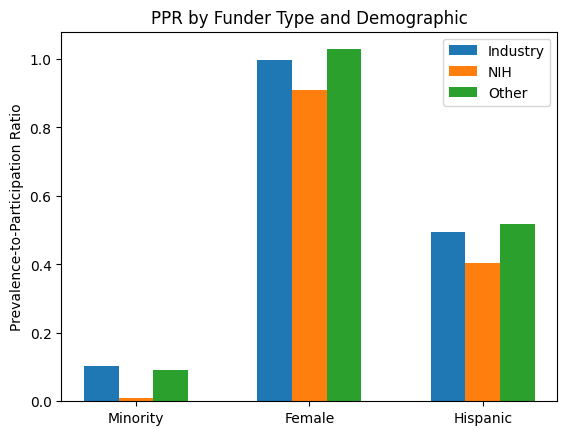

In [58]:
# Plot participation rates for all three funder types as bar charts.
# x-axis is participation type: minority_surgery_participation_rate, female_participation_rate, hispanic_participation_rate
# Funder Type == "INDUSTRY", "NIH", and "OTHER". Group the three funder types together for each participation type.
# y-axis is participation rate
participation_types = ["Minority", "Female", "Hispanic"]
industry_participation_rates = [merged_df[merged_df["Funder Type"] == "INDUSTRY"]["minority_participation_rate"].mean(),
                                merged_df[merged_df["Funder Type"] == "INDUSTRY"]["female_participation_rate"].mean(),
                                merged_df[merged_df["Funder Type"] == "INDUSTRY"]["hispanic_participation_rate"].mean()]
nih_participation_rates = [merged_df[merged_df["Funder Type"] == "NIH"]["minority_participation_rate"].mean(),
                           merged_df[merged_df["Funder Type"] == "NIH"]["female_participation_rate"].mean(),
                           merged_df[merged_df["Funder Type"] == "NIH"]["hispanic_participation_rate"].mean()]
other_participation_rates = [merged_df[merged_df["Funder Type"] == "OTHER"]["minority_participation_rate"].mean(),
                             merged_df[merged_df["Funder Type"] == "OTHER"]["female_participation_rate"].mean(),
                             merged_df[merged_df["Funder Type"] == "OTHER"]["hispanic_participation_rate"].mean()]

x = np.arange(len(participation_types))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, industry_participation_rates, width, label='Industry')
rects2 = ax.bar(x, nih_participation_rates, width, label='NIH')
rects3 = ax.bar(x + width, other_participation_rates, width, label='Other')

ax.set_ylabel('Prevalence-to-Participation Ratio')
ax.set_title('PPR by Funder Type and Demographic')
ax.set_xticks(x)
ax.set_xticklabels(participation_types)
ax.legend()
plt.savefig("../plots/ppr_by_funder_and_demographic.png", dpi=1200)
plt.savefig("../plots/ppr_by_funder_and_demographic.svg", format="svg", dpi=1200)
plt.show()

In [66]:
# 6. Has reporting of ethnicity or race changed over time?

# Group by year and get rate of reporting for ethnicity. i.e. per year, rate of has_race == 1 versus has_race == 0
graph_six_df = df.groupby("Start Year").agg({"has_ethnicity": ["mean", "count"]})
graph_six_df.columns = ["ethnicity_reporting_rate", "total_patients"]

slope: 0.042645    intercept: -85.366126
R-squared: 0.937850
p-value: 0.000000


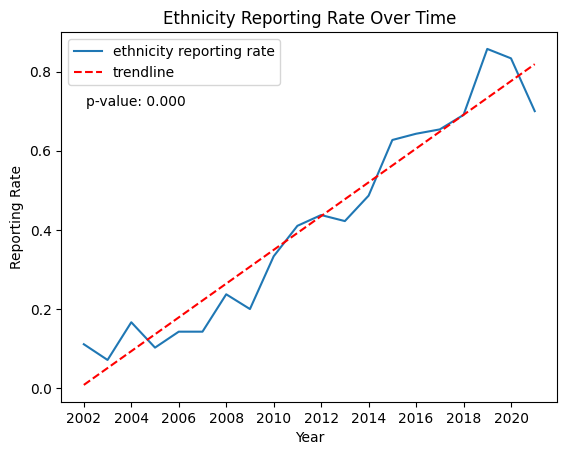

In [67]:
# Plot "ethnicity_reporting_rate" over time 2002-2021
graph_six_df = graph_six_df[graph_six_df.index >= 2002]
plt.plot(graph_six_df.index, graph_six_df["ethnicity_reporting_rate"], label="ethnicity reporting rate")

# Plot trendline and p-value to the graph
x = graph_six_df.index
y = graph_six_df["ethnicity_reporting_rate"]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.plot(x, intercept + slope*x, '--r', label='trendline')
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)
print("p-value: %f" % p_value)
plt.annotate(f"p-value: {p_value:.3f}", xy=(0.05, 0.80), xycoords='axes fraction')

plt.title("Ethnicity Reporting Rate Over Time")
plt.xlabel("Year")
plt.xticks(graph_six_df.index[::2])
plt.ylabel("Reporting Rate")
plt.legend()
plt.savefig("plots/ethnicity_reporting_rate_over_time.png", dpi=1200)
plt.savefig("plots/ethnicity_reporting_rate_over_time.svg", format="svg", dpi=1200)
plt.show()

slope: 0.041881    intercept: -83.647993
R-squared: 0.847186
p-value: 0.000000


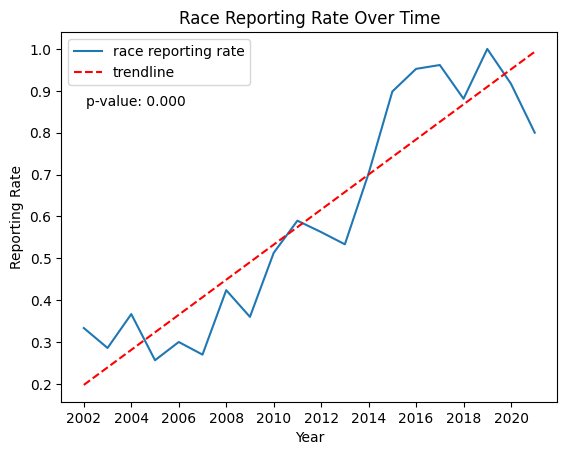

In [68]:
# Group by year and get rate of reporting for race. i.e. per year, rate of has_race == 1 versus has_race == 0
graph_six_df = df.groupby("Start Year").agg({"has_race": ["mean", "count"]})
graph_six_df.columns = ["race_reporting_rate", "total_patients"]

graph_six_df = graph_six_df[graph_six_df.index >= 2002]
plt.plot(graph_six_df.index, graph_six_df["race_reporting_rate"], label="race reporting rate")

# Plot trendline and p-value to the graph
x = graph_six_df.index
y = graph_six_df["race_reporting_rate"]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.plot(x, intercept + slope*x, '--r', label='trendline')
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)
print("p-value: %f" % p_value)
plt.annotate(f"p-value: {p_value:.3f}", xy=(0.05, 0.80), xycoords='axes fraction')

plt.title("Race Reporting Rate Over Time")
plt.xlabel("Year")
plt.xticks(graph_six_df.index[::2])
plt.ylabel("Reporting Rate")
plt.legend()
plt.savefig("plots/race_reporting_rate_over_time.png", dpi=1200)
plt.savefig("plots/race_reporting_rate_over_time.svg", format="svg", dpi=1200)
plt.show()